# Test notebook

Getting started on computer vision project to identify color charts. Test notebook for small code snippets.

### Initial Observations
- Canny edge detection more accurate than contour detection but includes a lot of extraneous detail
- Selective (bilateral) filter blur sacrifices some accuracy especially black square but greatly reduces extraneous detail
- Equalizing histogram then selectively blurring seems to be good balance
- Either match canny edges or contours to that of target color chart layout

### Notes on method
- We can break down method into 1) feature extraction, which is the problem solved by filtering and edge/region detection, 2) feature matching, and 3) regularization with a deformation model e.g. restrict to rigid deformations, see [1] for details
- Feature matching approaches include (a) nearest neighbor projection-based distances like Iterative Closest Point (ICP) and Coherent Point Drift (CPD), (b) convolutional norms like Energy Distance or Maximum Mean Discrepancies (MMD) which are "common" in many applications but "suffer from vanishing gradients", and (c) optimal transport methods which provide reliable solutions in some contexts but historically not robust/scalable in presence of outliers and noise
- Since we only need to identify one very specific shape, try 1) equalizing contrast, 2) filtering out noise, 3) edge detection, 4) OT-based feature matching with regularization
- Works well when color chart is one of the highest-contrast objects in the image, probably ok for calibration images
- We can probably assume that target image has ok contrast and can be adjusted to have clean edges manually if necessary, so start with target_edges

#### References

[1](https://arxiv.org/abs/2111.00648) Shen et al. 2021, Accurate Point Cloud Registration with Robust Optimal Transport, arXiv:2111.00648 [cs.CV]

[2](https://ieeexplore.ieee.org/abstract/document/5432191?casa_token=Is0u1RqYLl4AAAAA:CPfuz5P2DfKKo41wRWmIRQT8qz4kJhJtn1mzudXIq9y02Lib9MKp7m9Ngrgino_BPX5dqhQc) Myronenko et al. 2010, Point Set Registration: Coherent Point Drift.

[3](https://en.wikipedia.org/wiki/Maximally_stable_extremal_regions) Maximally stable extremal regions.

In [82]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

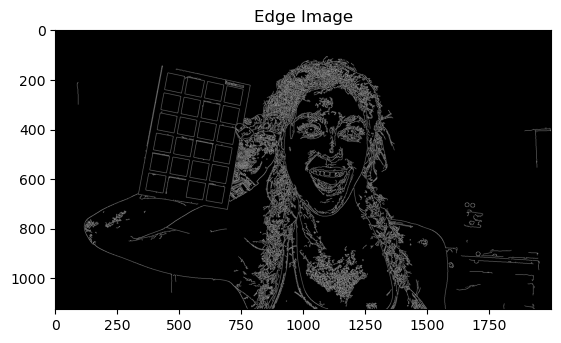

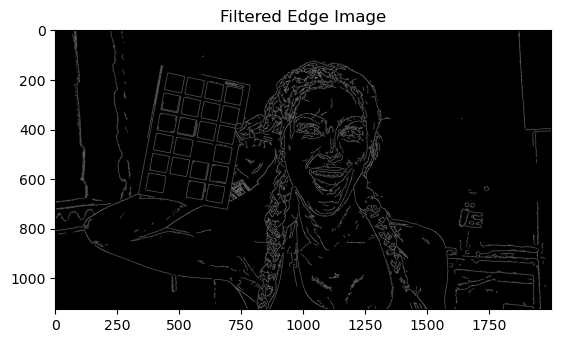

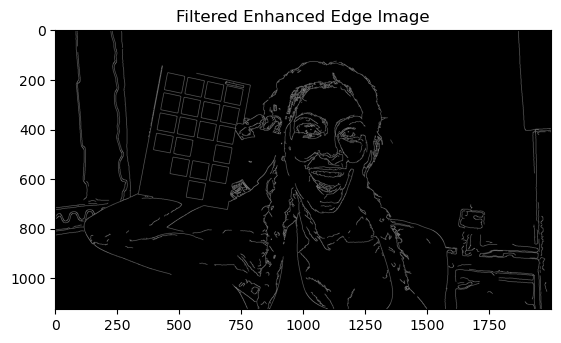

In [228]:
# test canny edge detection
img = cv.imread('test_img/2.jpg', cv.IMREAD_GRAYSCALE)
# img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,15)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img,30,80)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(img,10,50,50)
edges = cv.Canny(blur,30,10)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Edge Image')
plt.show()

# test with equalize then selective blur
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,10,50,50)
edges = cv.Canny(blur,30,80)
plt.clf()
plt.imshow(edges,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()

# f = open('data/target_edges.txt','w')
# f.write(str(np.array(edges)))
# f.close()

In [ ]:
## test corner detection
img = cv.imread('test_img/reference.png', cv.IMREAD_GRAYSCALE)
# gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
corners = cv.goodFeaturesToTrack(img,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(img,(x,y),3,255,-1)
plt.imshow(img,cmap = 'gray'),plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(img,12,50,50)
corners = cv.goodFeaturesToTrack(blur,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(blur,(x,y),3,255,-1)
plt.imshow(blur,cmap = 'gray'),plt.show()

# test with equalize then selective blur
dst = cv.equalizeHist(img)
blur = cv.bilateralFilter(dst,12,50,50)
corners = cv.goodFeaturesToTrack(blur,80,0.01,10)
corners = np.int0(corners)
for i in corners:
    x,y = i.ravel()
    cv.circle(blur,(x,y),3,255,-1)
plt.imshow(blur,cmap = 'gray'),plt.show()

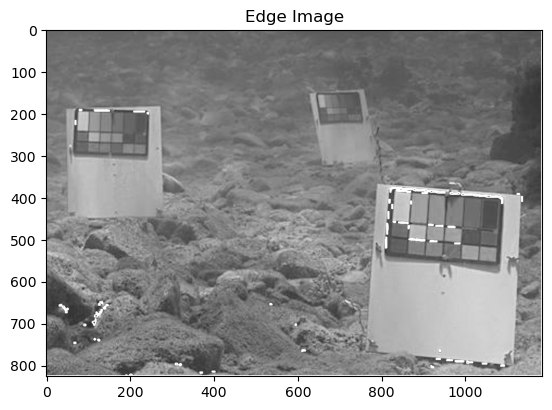

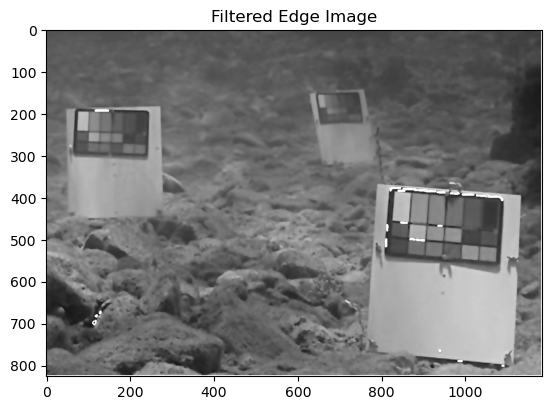

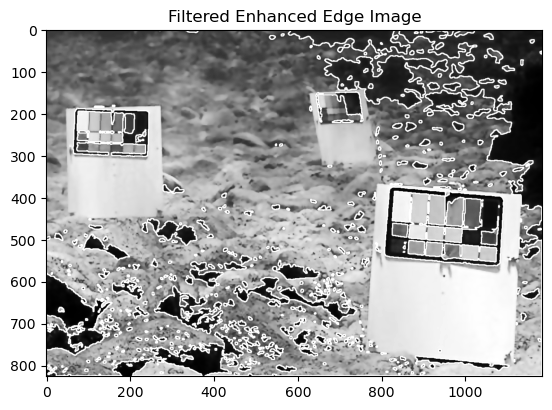

In [179]:
im = cv.imread('test_img/1c.png', cv.IMREAD_GRAYSCALE)
assert im is not None, "file could not be read, check with os.path.exists()"
# imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(im, 50, 30, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = im.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Edge Image')
plt.show()

# test with selective filter blur
blur = cv.bilateralFilter(im,10,25,25)
ret, thresh = cv.threshold(blur, 50, 30, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = blur.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Filtered Edge Image')
plt.show()

# test with equalize then selective blur
dst = cv.equalizeHist(im)
blur = cv.bilateralFilter(dst,10,25,25)
ret, thresh = cv.threshold(blur, 50, 30, 0)
contours = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
cnt = []
for c in contours:
    if cv.arcLength(c,True) > 10:
#         cnt.append(cv.convexHull(c))
        cnt.append(c)
result = blur.copy()
cv.drawContours(result, cnt, -1, (255,0,0), 2)
plt.clf()
plt.imshow(result,cmap = 'gray')
plt.title('Filtered Enhanced Edge Image')
plt.show()

In [ ]:
# test detection by comparing canny edges
